### Mark Hoogendoorn and Burkhardt Funk (2017)              
Machine Learning for the Quantified Self               
Springer,
Chapter 4     

In [1]:
from util.VisualizeDataset import VisualizeDataset
from Chapter4.TemporalAbstraction import NumericalAbstraction
from Chapter4.TemporalAbstraction import CategoricalAbstraction
from Chapter4.FrequencyAbstraction import FourierTransformation
from Chapter4.TextAbstraction import TextAbstraction
import copy
import pandas as pd
import numpy as np

C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\gensim\utils.py:840: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\gensim\utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
# Let us create our visualization class again.
DataViz = VisualizeDataset()

In [3]:
# Read the result from the previous chapter, and make sure the index is of the type datetime.
dataset_path = 'intermediate_datafiles/'
try:
    dataset = pd.read_csv(dataset_path + 'chapter3_result_final.csv', index_col=0)
except IOError as e:
    print('File not found, try to run previous crowdsignals scripts first!')
    raise e

dataset.index = dataset.index.to_datetime()

# Compute the number of milliseconds covered by an instane based on the first two rows
milliseconds_per_instance = (dataset.index[1] - dataset.index[0]).microseconds/1000

C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  if __name__ == '__main__':


In [4]:
dataset.shape

(9009, 18)

In [5]:
# creating sum of squares attributes from accelerometer and gyroscope data
acc_r = (dataset['acc_x']**2+dataset['acc_y']**2+dataset['acc_z']**2)
gyr_r = (dataset['gyr_x']**2+dataset['gyr_y']**2+dataset['gyr_z']**2)
dataset['acc_r'] = np.sqrt(acc_r)
dataset['gyr_r'] = np.sqrt(gyr_r)

In [6]:
# Time domain.
# Set the window sizes to the number of instances representing 1 seconds, 5 seconds and 8 seconds
window_sizes = [int(float(400)/milliseconds_per_instance), int(float(800)/milliseconds_per_instance), int(float(1000)/milliseconds_per_instance)]

NumAbs = NumericalAbstraction()
dataset_copy = copy.deepcopy(dataset)
for ws in window_sizes:
    dataset_copy = NumAbs.abstract_numerical(dataset_copy, ['acc_y'], ws, 'mean')
    dataset_copy = NumAbs.abstract_numerical(dataset_copy, ['acc_y'], ws, 'std')

util\VisualizeDataset.py:36: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plot.hold(True)
C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\matplotlib\__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\matplotlib\rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


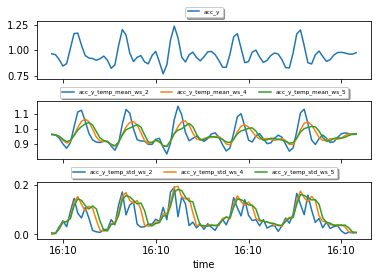

In [7]:
DataViz.plot_dataset(dataset_copy[(dataset.labelBenchPress == 1) & (dataset_copy.set == 1) & (dataset_copy.category == 'heavy')], ['acc_y', 'acc_y_temp_mean', 'acc_y_temp_std'], ['exact', 'like', 'like'], ['line', 'line', 'line'])

In [8]:
ws = int(float(800)/milliseconds_per_instance)
selected_predictor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'acc_r', 'gyr_r']
dataset = NumAbs.abstract_numerical(dataset, selected_predictor_cols, ws, 'mean')
dataset = NumAbs.abstract_numerical(dataset, selected_predictor_cols, ws, 'std')

In [9]:
# Now we move to the frequency domain, with the same window size.

FreqAbs = FourierTransformation()
fs = 1

periodic_predictor_cols = ['acc_r', 'gyr_r']
data_table = FreqAbs.abstract_frequency(copy.deepcopy(dataset), ['acc_r'], int(float(800)/milliseconds_per_instance), fs)

C:\Users\davee\Anaconda3\envs\ml4qs\lib\site-packages\matplotlib\axes\_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


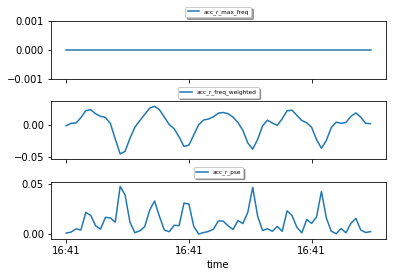

In [10]:
DataViz.plot_dataset(data_table[data_table['set'] == data_table['set'].unique()[6]], ['acc_r_max_freq', 'acc_r_freq_weighted', 'acc_r_pse'], ['like', 'like', 'like'], ['line', 'line', 'line'])

### Apply to dataset

In [11]:
dataset = FreqAbs.abstract_frequency(dataset, periodic_predictor_cols, int(float(800)/milliseconds_per_instance), fs)

In [12]:
dataset.shape

(9009, 48)

In [13]:
# The percentage of overlap we allow
window_overlap = 0.50
skip_points = int((1-window_overlap) * ws)
dataset = dataset.iloc[::skip_points,:]

In [14]:
dataset.shape

(4505, 48)

In [15]:
dataset.to_csv(dataset_path + 'chapter4_result.csv')